# Model for Image Classification of Cats and Dogs 
## 1. Import Modules 

In [1]:
import os
import sys
import glob
import random

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

tf_version=float('.'.join(tf.__version__.split('.')[0:2]))

if tf_version > 2.8:
    import keras.utils as image

else:
    from keras.preprocessing import image

path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')


from image_classification_functions import prep_data
from image_classification_functions import single_training_run
from image_classification_functions import plot_single_training_run
from image_classification_functions import hyperparameter_optimization_run
from image_classification_functions import plot_hyperparameter_optimization_run

tf.get_logger().setLevel('ERROR')


tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

2025-04-22 20:17:28.185801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745353048.418802   21897 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745353048.509420   21897 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745353049.155339   21897 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745353049.155381   21897 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745353049.155384   21897 computation_placer.cc:177] computation placer alr

## 2. Data Preparation 

In [2]:
training_data_path, validation_data_path, testing_data_path=prep_data()

training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs=glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats=glob.glob(f'{validation_data_path}/cats/cat.*')

Not running in Kaggle notebook
Checking data prep
Data prep already complete


### 2.1 Data Inspection 
#### 2.1.1 Training Data set 

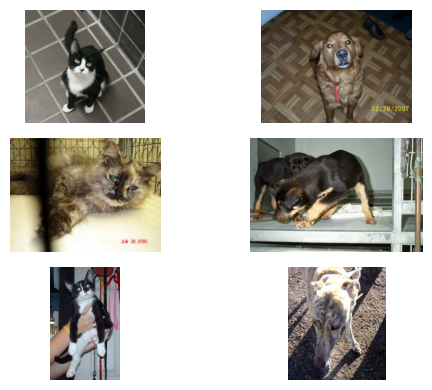

In [3]:

fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

#### 2.1.2 Validation Dataset 

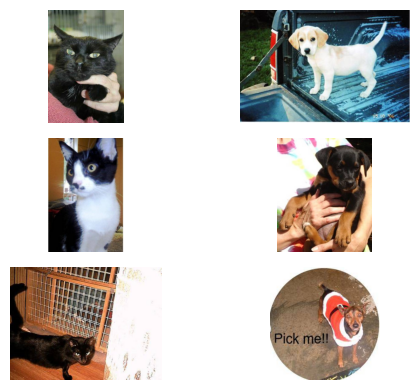

In [4]:

fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(validation_cats, validation_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

## 3. EDA 
### 3.1 Image data 

In [5]:

dog=image.load_img(training_dogs[0])

dog=image.img_to_array(dog)

print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (375, 499, 3)


- Image array has a shape of 375 x 499 x 3 pixels. 

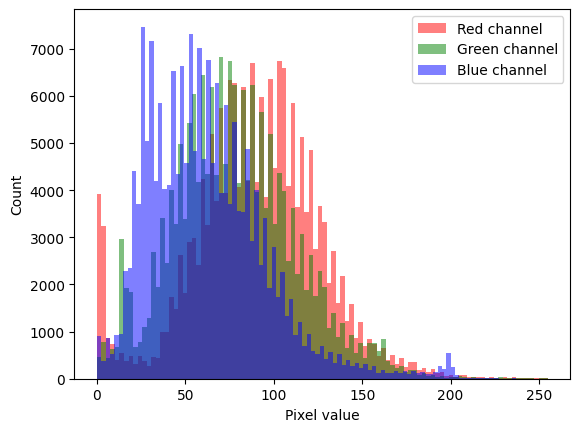

In [6]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

- Image array has 3 axes of 375 x 499 x 3: first two are the image dimensions and third is 3 color channels referring to primary colors red, blue and green 
- One image is has over half million values and one image is 10 times more data than any other data set we have worked so far! 
- Range of pixel value is 0 to 255 Standard JPEG image standard. 
Two options 
1. Scale pixel values - to improve neural net training. This can be done by adding normalization layer! 
2. Images can be made grey scale, thereby decreasing input size and reducing the computation burden by 3. This can be done by image dataset generator! 

### 3.2 Image dimensions 

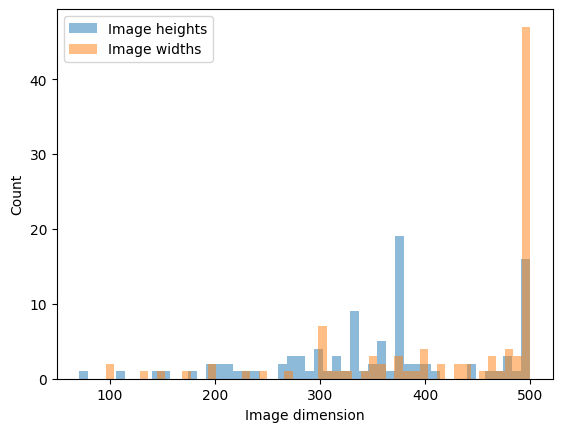

In [7]:

sample_size=100
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

for sample_image in sample:

    
    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)


    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])


plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

- Based on the above plot, image dimension can be set to 64 or 128 pixels. 
- Smaller is better for training speed and memory usage!
- Good balance should be found for proper model training! 



### 3.3 IMage Aspect ratio 

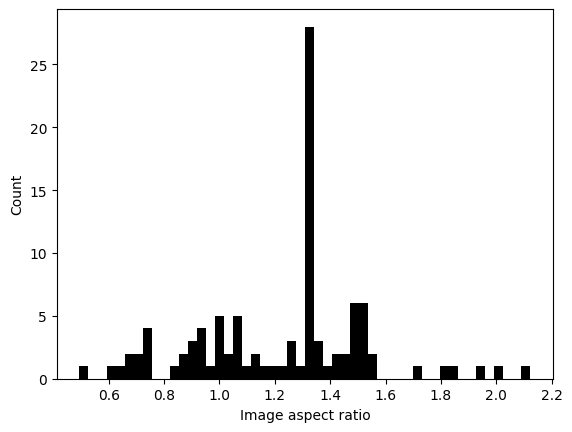

In [8]:

aspect_ratios=np.array(widths)/np.array(heights)

plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

- Most common aspect ratio is around 1.3 referring to 4:3 standard computer monitor! 
- Better to choose this aspect ratio in comparison to a smaller square input images! 

In [9]:
image_width=64
aspect_ratio=4/3
image_height=int(image_width / aspect_ratio)

## 4. Model 

Steps for Model build and training: 
1. Evaluate the baseline performance with default settings 
2. Optimize batch size and learning rate 
3. Optimize regularization with L1/L2 penalties 
4. Optimize input image size for speed and better performance 
5. Optimize network architecture 
6. Final model and evaluation 


In [10]:
epochs=5
steps_per_epoch=10
validation_steps=10

### 4.1 Baseline Model performance 

Found 15000 files belonging to 2 classes.


2025-04-22 20:17:38.864306: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 5000 files belonging to 2 classes.
Training run already complete, loading results from disk.


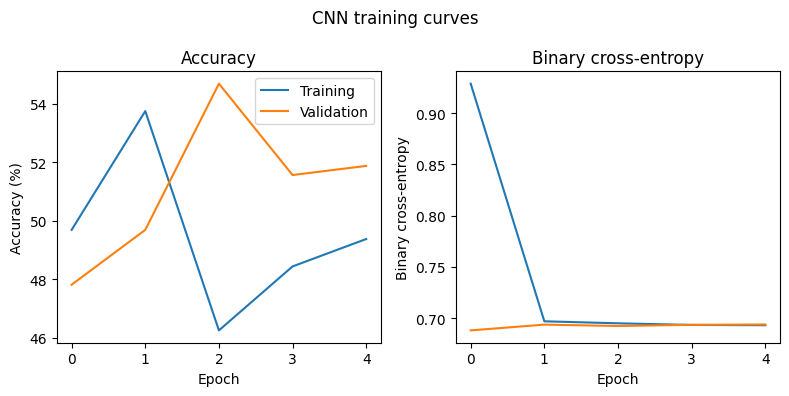


CPU times: user 1.09 s, sys: 465 ms, total: 1.55 s
Wall time: 1.68 s


In [11]:
%%time

training_results=single_training_run(
    training_data_path,
    validation_data_path,
    image_height=image_width,
    image_width=image_height,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    print_model_summary=True
)

plot_single_training_run(training_results).show()

print()

### 4.2 Batch size and learning rate optimization 

### 4.3 Regularization 
Optimize L1 and L2 penalties using optimized batch size and learning rate from previous experiment! 

### 4.4 Input Image size optimization 

 ### 4.5 Model Architecture 
 #### 4.5.1 Convolution layers 